In [1]:
import torch
import train
import model
import numpy as np
import csvLoader as cl
import visualizer as vs
import dataLoader as dl
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler, SequentialSampler

C:\Users\56265\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\56265\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\56265\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


GPU mode: True
Len of train csv: 7049
Loading Dataset...
Randomly Visualizing...


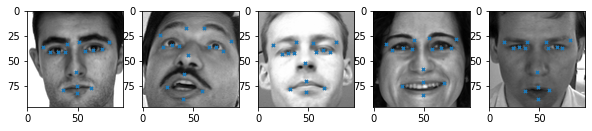

In [2]:
TRAIN_CSV_PATH = 'facial-keypoints-detection/training/training.csv'
TEST_CSV_PATH = 'facial-keypoints-detection/test/test.csv'

USE_GPU, device = train.check_GPU()
print('GPU mode: {}'.format(USE_GPU))

train_csv = cl.load_csv(TRAIN_CSV_PATH)

print(f'Len of train csv: {len(np.array(train_csv.Image))}')
csv_allValid, csv_autoFill, csv_missingOnly = cl.clean_csv(train_csv)

print('Loading Dataset...')
allValid_dataset = dl.FacialKptsDataSet(csv_allValid)
print('Randomly Visualizing...')
vs.rand_vis_dataset(allValid_dataset, 5)

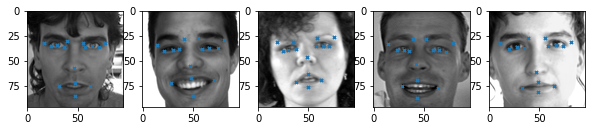

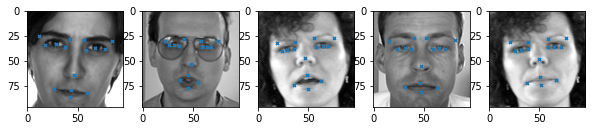

In [3]:
allValidTrain, allValidVal = dl.getTrainValidationDataSet(csv_allValid, 0.85)
vs.rand_vis_dataset(allValidTrain, 5)
vs.rand_vis_dataset(allValidVal, 5)

In [4]:
print('Size of Training set: {}\nSize of Validation set: {}'.format(len(allValidTrain), len(allValidVal)))
print('Size of all valid set: {}'.format(len(csv_allValid)))

Size of Training set: 1819
Size of Validation set: 321
Size of all valid set: 2140


In [5]:
train_sampler = SubsetRandomSampler(range(len(allValidTrain)))
val_sampler = SubsetRandomSampler(range(len(allValidVal)))

train_loader = torch.utils.data.DataLoader(allValidTrain, batch_size=30, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(allValidVal, batch_size=30, sampler=val_sampler)

print('Size of training loader batches: {}\nSize of validation loader batches: {}'.format(len(train_loader), len(val_loader)))

Size of training loader batches: 61
Size of validation loader batches: 11


In [7]:
fc_model = model.FullyConnectNet()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(fc_model.optim, 'min',verbose=True, patience=5)
train.train_model(fc_model, train_loader, val_loader, epochs=150)

Epoch 00053: reducing learning rate of group 0 to 1.0000e-03.
Epoch: 1/150  Average Training Loss: 17.4986 Average Val Loss: 10.6077
Improvement Detected, Saving to ./best_model.pt
Epoch 00065: reducing learning rate of group 0 to 1.0000e-04.
Epoch 00071: reducing learning rate of group 0 to 1.0000e-05.
Epoch 00085: reducing learning rate of group 0 to 1.0000e-06.
Epoch 00096: reducing learning rate of group 0 to 1.0000e-07.
Epoch 00103: reducing learning rate of group 0 to 1.0000e-08.
Epoch: 2/150  Average Training Loss: 8.9860 Average Val Loss: 10.3103
Improvement Detected, Saving to ./best_model.pt
Epoch: 3/150  Average Training Loss: 8.8281 Average Val Loss: 10.3653
Epoch: 4/150  Average Training Loss: 8.8664 Average Val Loss: 10.1981
Improvement Detected, Saving to ./best_model.pt
Epoch: 5/150  Average Training Loss: 8.8754 Average Val Loss: 10.3370
Epoch: 6/150  Average Training Loss: 8.8717 Average Val Loss: 10.3305
Epoch: 7/150  Average Training Loss: 8.8664 Average Val Loss: 1

KeyboardInterrupt: 